In [1]:
#!pip install matplotlib

In [2]:
%matplotlib widget
import os
import csv
import random
from pathlib import Path
import pandas as pd
import numpy as np
#import matplotlib
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

mpl.rcParams['axes3d.mouserotationstyle'] = 'azel'

#%matplotlib inline

hole_indexes = ['2-5', '2-6', '3-2', '3-3', '4-5']
filenames = [idx + " - Borehole Deviation Data_accurate.csv" for idx in hole_indexes]

#source_folder = Path(r'C:\Users\howar\OneDrive - ballingercloud\Documents\umb boreholes')
source_folder = Path(r'C:\Users\DHoward\OneDrive - ballingercloud\Documents\umb boreholes')
filepaths = [source_folder / fn for fn in filenames]

### Dataframe parameters
 - idx - Index of measurement
 - dz, dy, dx - XYZ coordinates of measurement, relative to origin of borehole
 - total_dev_ft, total_dev_pct - from original data, total deviation
 - delta_dx, delta_dy, delta_dz - difference in XYZ coordinate from previous point, ie: the vector coordinates of the move from one point to another
 - ddx, ddy, ddz - difference in amount of change from previous point - ie: did the move between points change direction or stay the same
   - asdfaf

In [1]:
def process_borehole(filepath, hole_index):
    df = pd.read_csv(filepath)
    df.dropna(inplace=True)
    df = df.set_axis(['idx', 'z', 'y', 'x', 'total_dev_ft', 'total_dev_pct'], axis=1)
    df = df[0::10] # only getting entries every 10 linear feet, could remove for every 1 foot spacing
    df.insert(1, 'hole_index', hole_index)

    df['z'] = - df['z']
    
    df['position_angle'] = np.arctan2(df['y'], df['x'])
    
    df['delta_x'] = df['x'] - df['x'].shift(1, fill_value=None)
    df['delta_y'] = df['y'] - df['y'].shift(1, fill_value=None)
    df['delta_z'] = df['z'] - df['z'].shift(1, fill_value=None)
    df['velocity_angle'] = np.arctan2(df['delta_y'], df['delta_x'])

    # to get the change in direction, need to get the difference between this delta and previous delta

    df['ddx'] = df['delta_x'] - df['delta_x'].shift(1, fill_value=None)
    df['ddy'] = df['delta_y'] - df['delta_y'].shift(1, fill_value=None)
    df['ddz'] = df['delta_z'] - df['delta_z'].shift(1, fill_value=None)
    df['acceleration_angle'] = np.arctan2(df['ddy'], df['ddx'])

    df['jx'] = df['ddx'] - df['ddx'].shift(1, fill_value=None)
    df['jy'] = df['ddy'] - df['ddy'].shift(1, fill_value=None)
    df['jz'] = df['ddz'] - df['ddz'].shift(1, fill_value=None)

    df['abs_ddx'] = df['ddx'].abs()
    df['abs_ddy'] = df['ddy'].abs()
    df['abs_ddz'] = df['ddz'].abs()

    df['d_dist'] = np.sqrt(
        (df['x'] - df['x'].shift(1))**2 +
        (df['y'] - df['y'].shift(1))**2 +
        (df['z'] - df['z'].shift(1))**2
    )
    df['d_dist_error'] = (df['d_dist'] - 10).abs()

    return df

total_stats = pd.DataFrame()
for fp, hi in zip(filepaths, hole_indexes):
    #print(fp, hi)
    df = process_borehole(fp, hi)
    #print(df.loc[0:1])
    df = df[3:]
    total_stats = pd.concat([total_stats, df])

#total_stats = total_stats.set_index(['idx', 'hole_index']) 
total_stats = total_stats.reset_index().drop('index', axis=1)
total_stats[['idx', 'hole_index', 'x', 'y', 'z', 'position_angle', 'delta_x', 'delta_y', 'delta_z', 'ddx', 'ddy', 'ddz', 'jx', 'jy', 'jz']]


NameError: name 'pd' is not defined

## Visualize Overall Stats

<Axes: title={'center': 'jerk over depth'}, xlabel='idx'>

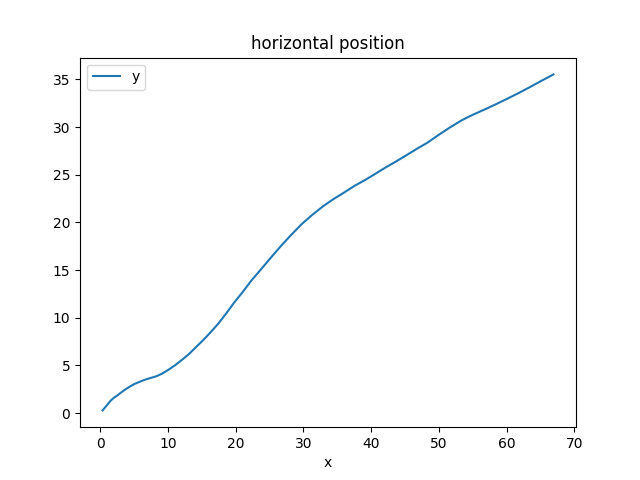

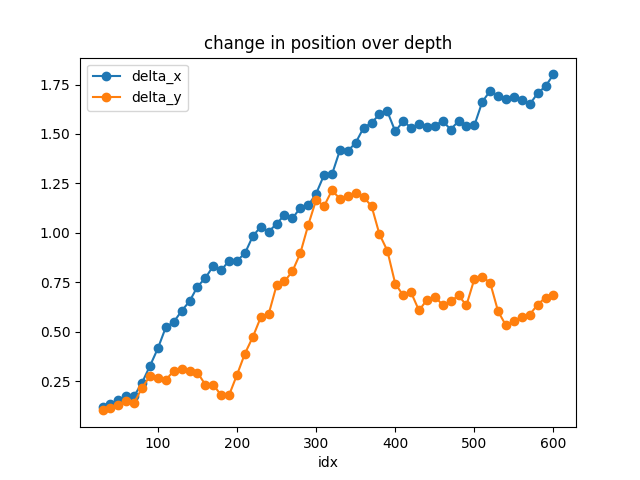

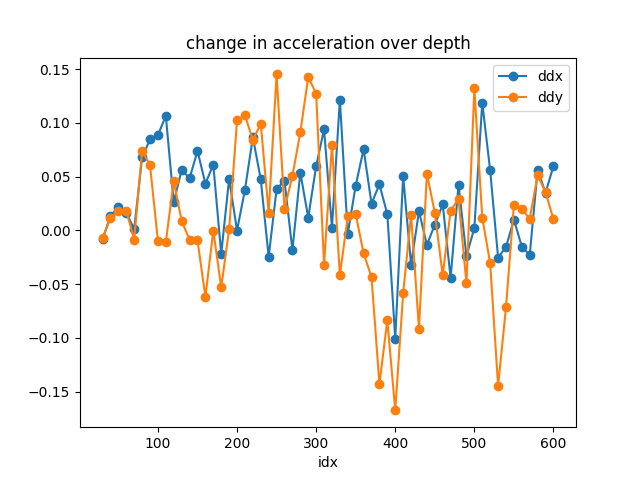

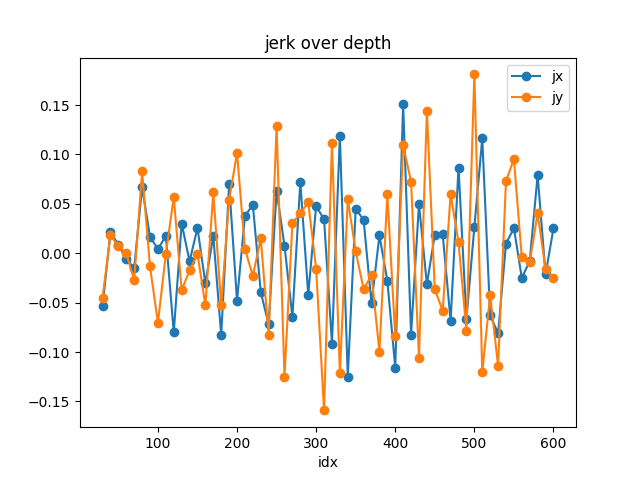

In [30]:
selected_borehole = hole_indexes[0]
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='x', y='y', title='horizontal position')
#total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y='position_angle', title='position angle over depth', ylim=(-3.14, 3.14))
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y=['delta_x','delta_y'], title='change in position over depth', marker='o')
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y=['ddx','ddy'], title='change in acceleration over depth', marker='o')
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y=['jx','jy'], title='jerk over depth', marker='o')


array([[<Axes: title={'center': 'angle'}>]], dtype=object)

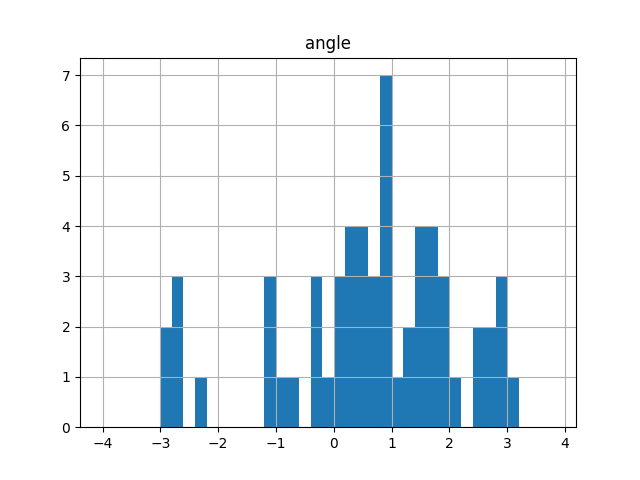

In [122]:
total_stats[total_stats['hole_index'] == '2-5'].hist(column='angle', bins=np.arange(-4, 4, 0.2))

array([[<Axes: title={'center': 'ddx'}>, <Axes: title={'center': 'ddy'}>],
       [<Axes: title={'center': 'ddz'}>, <Axes: >]], dtype=object)

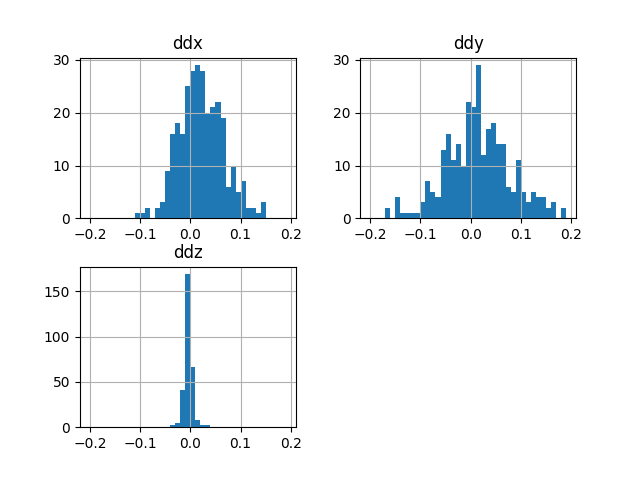

In [123]:
total_stats.hist(column=['ddx', 'ddy', 'ddz'], bins=np.arange(-0.2,0.2, 0.01))

<Axes: xlabel='idx'>

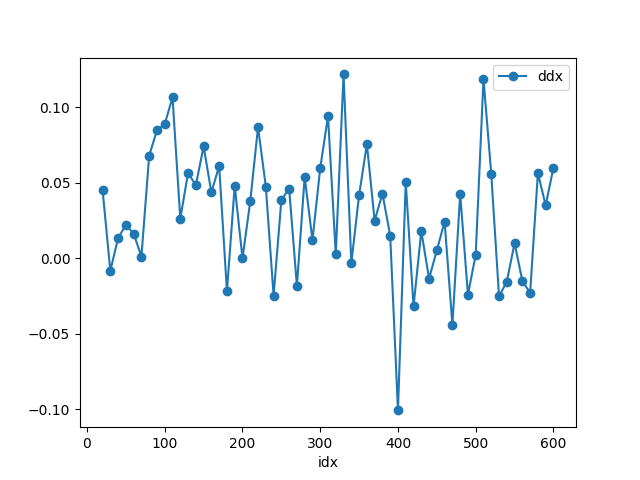

In [19]:
total_stats[total_stats['hole_index'] == '2-5'].plot.line(x='idx', y='ddx', marker='o')

## Simulation

### Simulate Borehole function


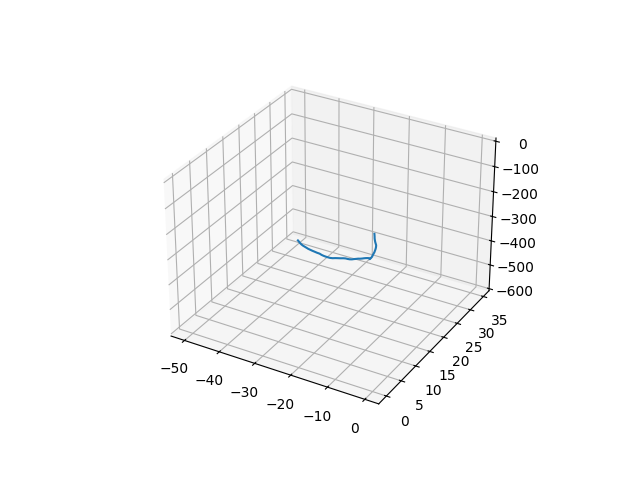

,x,y,z,delta_x,delta_y,delta_z,ddx,ddy,ddz
0,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.0000,0.00000,0.0
1,-0.03350,0.10713,-9.999370,-0.03350,0.10713,-9.999370,-0.0335,0.10713,0.0
2,-0.15330,0.27936,-19.997169,-0.11980,0.17223,-9.997799,-0.0863,0.06510,0.0
3,-0.26460,0.50909,-29.993910,-0.11130,0.22973,-9.996741,0.0085,0.05750,0.0
4,-0.36690,0.76242,-39.990178,-0.10230,0.25333,-9.996267,0.0090,0.02360,0.0
...,...,...,...,...,...,...,...,...,...
56,-45.27292,30.75176,-556.743884,-1.26493,0.85895,-9.882417,-0.0077,-0.00120,0.0
57,-46.54555,31.67931,-566.619108,-1.27263,0.92755,-9.875225,-0.0077,0.06860,0.0
58,-47.78368,32.65386,-576.494193,-1.23813,0.97455,-9.875084,0.0345,0.04700,0.0
59,-49.00681,33.69781,-586.364052,-1.22313,1.04395,-9.869859,0.0150,0.06940,0.0


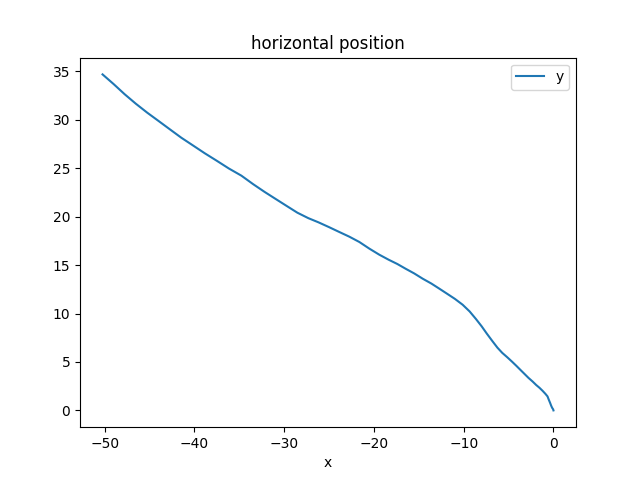

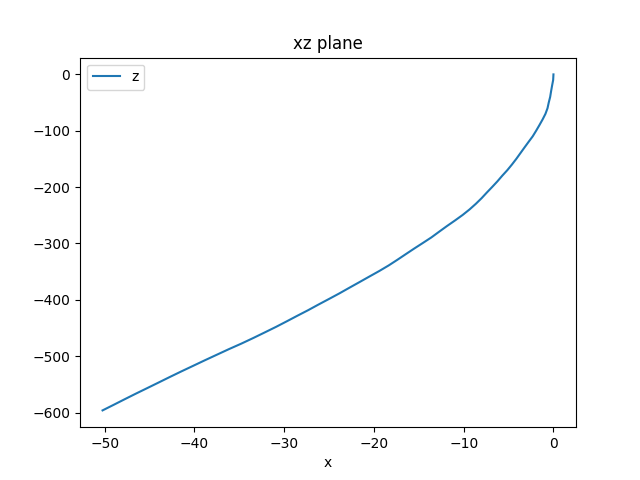

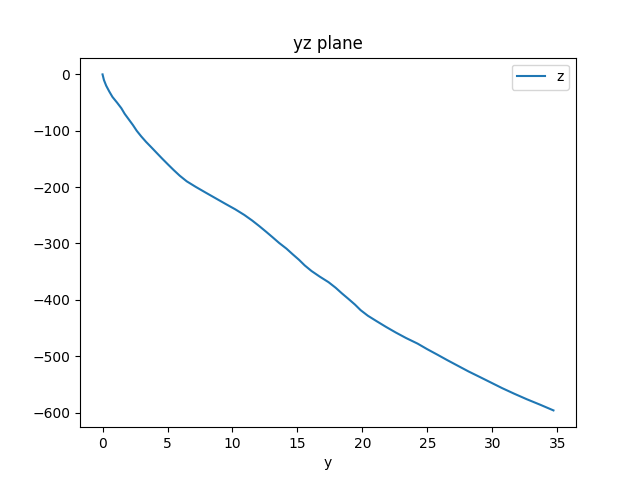

In [22]:
def get_delta_z(delta_x, delta_y, dist):
    delta_z = np.sqrt(dist**2 - delta_x**2 - delta_y**2) * -1 # change in z direction is always down
    return delta_z
    
def simulate_borehole():
    dist = 10
    df = pd.DataFrame(
        {'x': [0.0], 'y': [0.0], 'z': [0.0],
         'delta_x': [0.0], 'delta_y': [0.0], 'delta_z': [0.0],
         'ddx': [0.0], 'ddy': [0.0], 'ddz': [0.0]
        }
    )
    rand_x = np.random.choice([-1, 1])
    rand_y = np.random.choice([-1, 1])
    for i in range(60):
        new_i = len(df)
        df.loc[new_i] = df.loc[new_i-1]
        ddx = np.random.choice(total_stats['ddx']) * rand_x
        ddy = np.random.choice(total_stats['ddy']) * rand_y
        df.loc[new_i, 'ddx'] = ddx 
        df.loc[new_i, 'ddy'] = ddy 
        df.loc[new_i, 'delta_x'] = df.loc[new_i, 'delta_x'] + ddx
        df.loc[new_i, 'delta_y'] = df.loc[new_i, 'delta_y'] + ddy
        delta_z = get_delta_z(df.loc[new_i, 'delta_x'], df.loc[new_i, 'delta_y'], dist)
        df.loc[new_i, 'delta_z'] = delta_z

        df.loc[new_i, 'x'] = df.loc[new_i, 'x'] + df.loc[new_i, 'delta_x']
        df.loc[new_i, 'y'] = df.loc[new_i, 'y'] + df.loc[new_i, 'delta_y']
        df.loc[new_i, 'z'] = df.loc[new_i, 'z'] + df.loc[new_i, 'delta_z']
    return df
        
new_bh = simulate_borehole()
new_bh.plot.line(x='x', y='y', title='horizontal position')
new_bh.plot.line(x='x', y='z', title='xz plane')
new_bh.plot.line(x='y', y='z', title='yz plane')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(new_bh['x'], new_bh['y'], new_bh['z'], label='simulated borehole plot')
plt.show()

new_bh

In [79]:
np.random.choice(total_stats['abs_ddx'])

np.float64(0.011299999999998533)

array([[<Axes: title={'center': 'abs_ddx'}>,
        <Axes: title={'center': 'abs_ddy'}>],
       [<Axes: title={'center': 'abs_ddz'}>, <Axes: >]], dtype=object)

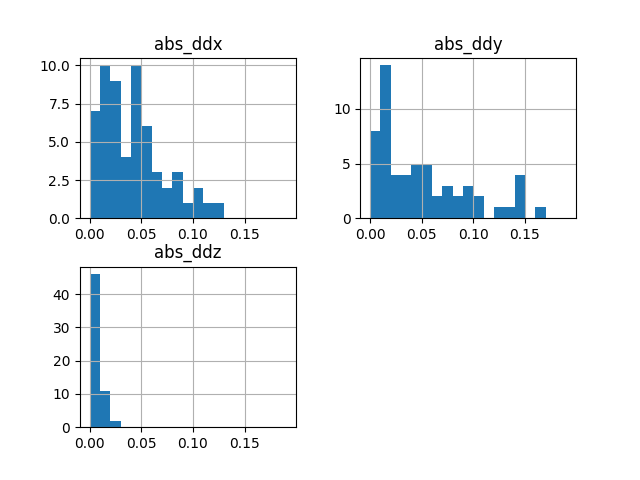

In [39]:
bh_0.hist(column=['abs_ddx', 'abs_ddy', 'abs_ddz'], bins=np.arange(0,0.2, 0.01))

In [3]:
# crate dataframe of first borehole
# TODO dataframes of all boreholes
df = pd.read_csv(filepaths[1])
df.dropna(inplace=True)
df = df.set_axis(['idx', 'dz', 'dy', 'dx', 'total_dev_ft', 'total_dev_pct'], axis=1)
df = df[0::10] # only getting entries every 10 linear feet, could remove for every 1 foot spacing
df.tail()

,idx,dz,dy,dx,total_dev_ft,total_dev_pct
560,560.0,559.0,10.2,14.4,17.7,3.2
570,570.0,568.9,10.9,14.7,18.3,3.2
580,580.0,578.9,11.6,14.9,18.9,3.3
590,590.0,588.9,12.3,15.2,19.5,3.3
600,600.0,598.8,12.9,15.5,20.2,3.4


In [5]:
# calculate the differences in each xyz
# these values form the components of the vector from the previous location

df['delta_dx'] = df['dx'] - df['dx'].shift(1, fill_value=None)
df['delta_dy'] = df['dy'] - df['dy'].shift(1, fill_value=None)
df['delta_dz'] = df['dz'] - df['dz'].shift(1, fill_value=None)

# to get the change in direction, need to get the difference between this delta and previous delta

df['ddx'] = df['delta_dx'] - df['delta_dx'].shift(1, fill_value=None)
df['ddy'] = df['delta_dy'] - df['delta_dy'].shift(1, fill_value=None)
df['ddz'] = df['delta_dz'] - df['delta_dz'].shift(1, fill_value=None)

df.loc[df['ddx'].abs() < 0.001, 'ddx'] = 0
df.loc[df['ddy'].abs() < 0.001, 'ddy'] = 0
df.loc[df['ddz'].abs() < 0.001, 'ddz'] = 0

df.tail()



,idx,dz,dy,dx,total_dev_ft,total_dev_pct,delta_dx,delta_dy,delta_dz,ddx,ddy,ddz
560,560.0,559.0,10.2,14.4,17.7,3.2,0.2,0.6,10.0,-0.1,-0.1,0.0
570,570.0,568.9,10.9,14.7,18.3,3.2,0.3,0.7,9.9,0.1,0.1,-0.1
580,580.0,578.9,11.6,14.9,18.9,3.3,0.2,0.7,10.0,-0.1,0.0,0.1
590,590.0,588.9,12.3,15.2,19.5,3.3,0.3,0.7,10.0,0.1,0.0,0.0
600,600.0,598.8,12.9,15.5,20.2,3.4,0.3,0.6,9.9,0.0,-0.1,-0.1


In [6]:
bins = np.arange(-0.3, 0.3, 0.02)
bins

array([-3.00000000e-01, -2.80000000e-01, -2.60000000e-01, -2.40000000e-01,
       -2.20000000e-01, -2.00000000e-01, -1.80000000e-01, -1.60000000e-01,
       -1.40000000e-01, -1.20000000e-01, -1.00000000e-01, -8.00000000e-02,
       -6.00000000e-02, -4.00000000e-02, -2.00000000e-02,  2.77555756e-16,
        2.00000000e-02,  4.00000000e-02,  6.00000000e-02,  8.00000000e-02,
        1.00000000e-01,  1.20000000e-01,  1.40000000e-01,  1.60000000e-01,
        1.80000000e-01,  2.00000000e-01,  2.20000000e-01,  2.40000000e-01,
        2.60000000e-01,  2.80000000e-01])

In [7]:
#df[['ddx', 'ddy', 'ddz']]

In [8]:
#df[['ddx', 'ddy', 'ddz']].plot(kind='hist', bins=bins,subplots=True, title=['ddx', 'ddy', 'ddz'])

In [9]:
stats_list = ["min", "max", "mean", "median", "std", "skew"]
df.agg(
{
    "delta_dx": stats_list,
    "delta_dy": stats_list,
    "delta_dz": stats_list,
    "ddx": stats_list,
    "ddy": stats_list,
    "ddz": stats_list,
}
)

,delta_dx,delta_dy,delta_dz,ddx,ddy,ddz
min,-0.100000,-0.500000,9.900000,-0.200000,-0.200000,-0.100000
max,0.600000,0.800000,10.000000,0.200000,0.200000,0.100000
mean,0.258333,0.215000,9.980000,0.005085,0.011864,-0.001695
median,0.300000,0.500000,10.000000,0.000000,0.000000,0.000000
std,0.163947,0.490874,0.040338,0.095455,0.085268,0.062949
skew,-0.152911,-0.217161,-1.538739,-0.104015,0.284759,0.012085


In [10]:
#p1 = df.iloc[50, 6:9]
#p2 = df.iloc[51, 6:9]
#print(f"p1: {p1}\np2:{p2}\ndot: {p1.dot(p2)}")

In [11]:
#cols = df.columns[6:9]
#df['dot'] = (df[cols] * df[cols].shift(1)).sum(axis=1)
#df['dot'].std()

In [12]:
#df[2:].plot(x="idx", y="dot")

In [13]:
#df[abs(df["dot"] - 1) > 0.03 ].head()

In [14]:
#df.plot(x='idx', y='delta_dy')

In [15]:
#df.plot(x='idx', y='delta_dx')

In [16]:
#df[2:].plot(x='idx', y=['delta_dx', 'delta_dy'])

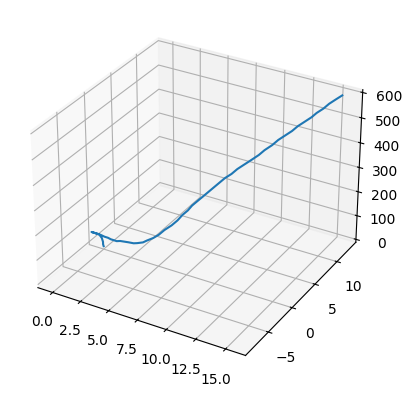

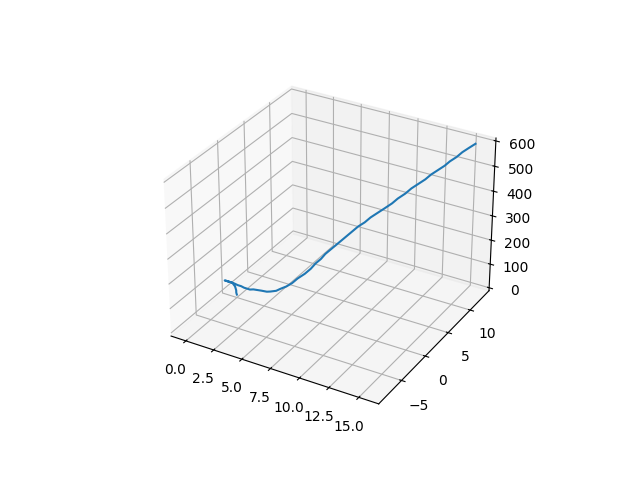

In [17]:
#ax = matplotlib.pyplot.figure().add_subplot(projection='3d')
#ax.plot(df['dx'][2:], df['dy'][2:], df['dz'][2:], label='test borehole plot')
#plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(df['dx'], df['dy'], df['dz'], label='test borehole plot')
#plt.show()
fig
